#Training model1_number

In [1]:
import numpy as np
import cv2
import sys
import random
import glob
import re
import time
import os
from tqdm.notebook import tqdm as log_progress
from matplotlib import pyplot as plt

from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

###Complete this basing on where you are running the notebook:

In [2]:
on_colab = False
EPOCHS = 10
LEN_TRAINING_DATA = 75000
if on_colab:
    !git clone https://github.com/andreorto98/scopa.git
    path_to_deck = './scopa/scopa/new_deck/'
if not on_colab:
    path_to_deck = './new_deck/'

In [3]:
def transform_img(img, angle = 0, scale = 1, tr = (0,0)):
  input_img_shape = img.shape
  img_center = (int(input_img_shape[0]/2), int(input_img_shape[1]/2))
  trasl_mat = np.zeros((2,3))
  trasl_mat[0,2]=tr[0]
  trasl_mat[1,2]=tr[1]
  trasl_mat[0,0] = trasl_mat[1][1] = 1
  img = cv2.warpAffine(img, trasl_mat, img.shape[0:2], flags=cv2.INTER_LINEAR)
  rot_mat = cv2.getRotationMatrix2D(img_center, angle, scale)
  img = cv2.warpAffine(img, rot_mat, img.shape[0:2], flags=cv2.INTER_LINEAR)
  return img.reshape(input_img_shape)

def generate_cards(n=1, layers=3, ang = True, traslate=False):
    cards = np.random.randint(1,41,n, np.uint8)
    if ang:
        angles= np.random.uniform(0,360,n)
    else:
        angles = np.full(n, 0.)
    scales= np.random.uniform(0.9,1.1,n)
    if layers == 1:
        print(path_to_deck+"*.jpg")
        inp_images = sorted([file for file in glob.glob(path_to_deck+"*.jpg")], key = string_to_n_card)
        inp_images = [cv2.imread(file, cv2.IMREAD_GRAYSCALE).reshape(256,256,1) for file in inp_images]
    elif layers == 3:
        inp_images = sorted([file for file in glob.glob("./deck0/*.jpg")], key = string_to_n_card)
        inp_images = [cv2.imread(file)[232:488,232:488] for file in inp_images]
    image_shape = inp_images[0].shape

    if traslate:
        marg = 5
        max_tr_x = int(image_shape[0]/2-image_shape[0]/marg)
        max_tr_y = int(image_shape[1]/2-image_shape[1]/marg)
        tr_x = np.random.randint(0,max_tr_x,n)
        tr_y = np.random.randint(0,max_tr_y,n)
    else:
        tr_x = np.zeros(n)
        tr_y = np.zeros(n)

    images = [transform_img(inp_images[cards[i]-1], angles[i], scales[i], (tr_x[i], tr_y[i]))
              for i in log_progress(range(len(cards)))]

    return np.array(images), np.array(cards)

def string_to_n_card(str):
    if str.startswith('.'):
         words = re.split('_|/|.j', str)[-3:-1]
    else: words = str.split('_')
    suit_to_n = {'hearts':0, 'diamonds':10, 'clubs':20, 'spades':30}
    return int(words[0])+suit_to_n[words[1]]

In [4]:
n_samples = LEN_TRAINING_DATA

print('start time1')
start = time.time()

# Generate training data1
train_data, target = generate_cards(n_samples, 1, True)

print(train_data.shape, target.shape)

print('cards_generated')
print("--- %s seconds ---" % (time.time() - start))

start time1
./new_deck/*.jpg


  0%|          | 0/75000 [00:00<?, ?it/s]

(75000, 256, 256, 1) (75000,)
cards_generated
--- 62.332233905792236 seconds ---


In [5]:
print(f'Dimension of train_data (MB): {sys.getsizeof(train_data)/1e6:.0f}', train_data.shape)


'''     MODEL1:
        Each image contains one card.
        The card is recognised looking separately to the suit and to the carder

        lo metteremo dentro una funzione train_model1()
'''

def card_to_number(card):
    target = np.zeros(10)
    target[(card-1)%10]=1.
    return target
    

model1 = True
if model1:
    # creating the ground truth labels
    labels = np.array([card_to_number(card) for card in target])

    # building the model: suit
    inputs = Input(shape=train_data[0].shape)
    conv = Conv2D(1, (3,3), activation = 'relu', input_shape=train_data[0].shape)(inputs)
    pool = MaxPooling2D(pool_size=(2,2))(conv)
    conv = Conv2D(2, (2,2), activation = 'relu')(pool)
    pool = MaxPooling2D(pool_size=(2,2))(conv)
    conv = Conv2D(3, (2,2), activation = 'relu')(pool)
    pool = MaxPooling2D(pool_size=(3,3))(conv)

    flatten = Flatten()(pool)
    dense = Dense(32, activation='relu')(flatten)
    outputs = Dense(10,activation='softmax')(dense)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['categorical_accuracy'])

    model.summary()
    history = model.fit(train_data, labels, validation_split=0.8, epochs= EPOCHS, verbose=1)
    
    print('end of training')
    print("--- %s seconds ---" % (time.time() - start))


Dimension of train_data (MB): 4915 (75000, 256, 256, 1)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 1)       10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 2)       10        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 3)         27        
_________________________________________________________________
max_p

./new_deck/*.jpg


  0%|          | 0/7500 [00:00<?, ?it/s]

Accuracy test set:	94.8%
val_categorical_accuracy
[0.950184166431427]
categorical_accuracy
[0.7222481369972229]


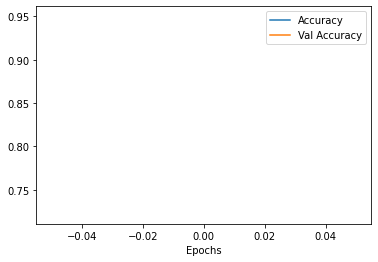

----------------------------------------------


In [6]:
test_data, target = generate_cards(int(n_samples/10), 1, True)

test_pred = model.predict(test_data)
test_pred = np.array([np.argmax(test_pred[i]) for i in range(len(test_pred))])
test_label = np.array([card_to_number(card) for card in target])
test_label = np.array([np.argmax(test_label[i]) for i in range(len(test_label))])

from sklearn import metrics

print(f'Accuracy test set:\t{metrics.accuracy_score(test_label, test_pred):.1%}')
print('val_categorical_accuracy')
print(history.history["val_categorical_accuracy"])
print('categorical_accuracy')
print(history.history["categorical_accuracy"])


plt.plot(history.history["categorical_accuracy"], label='Accuracy')
plt.plot(history.history["val_categorical_accuracy"], label='Val Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

print('----------------------------------------------')

In [8]:
save = False
if save:
  if on_colab:
    model.save('./scopa/scopa/new_models/numb_model.h5') 
  else:
    model.save('./new_models/numb_model.h5')